# Module 4 - Lab 1 - LLM Enhance LLM Application - Tools 
## Pre-requisites
> handled by codespace custom initialization
- ollama installed and running 
- python packages 
    - langchain
    - langchain-openai
    - langgraph

## Pull the LLM model

In [1]:
# ollama - pull the model
!ollama pull llama3.2:1b-instruct-q4_0

pulling manifest ⠋ pulling manifest ⠙ pulling manifest ⠹ pulling manifest ⠸ pulling manifest ⠼ pulling manifest ⠴ pulling manifest ⠦ pulling manifest ⠧ pulling manifest ⠇ pulling manifest ⠏ pulling manifest 
pulling b98b382ad859... 100% ▕████████████████▏ 770 MB                         
pulling 966de95ca8a6... 100% ▕████████████████▏ 1.4 KB                         
pulling fcc5a6bec9da... 100% ▕████████████████▏ 7.7 KB                         
pulling a70ff7e570d9... 100% ▕████████████████▏ 6.0 KB                         
pulling e9e2eec515fb... 100% ▕████████████████▏  485 B                         
verifying sha256 digest 
writing manifest 
success 


In [2]:
# list out LLMs available
!ollama list  

NAME                                                 ID              SIZE      MODIFIED      
llama3.2:1b-instruct-q4_0                            53f2745c8077    770 MB    8 seconds ago    
llama3.2:1b                                          baf6a787fdff    1.3 GB    2 days ago       
hf.co/bartowski/Llama-3.2-1B-Instruct-GGUF:IQ4_XS    0c8e6e099ddb    743 MB    2 weeks ago      
nomic-embed-text:latest                              0a109f422b47    274 MB    2 weeks ago      
llama3.2:3b                                          a80c4f17acd5    2.0 GB    3 weeks ago      
deepseek-r1:1.5b                                     a42b25d8c10a    1.1 GB    3 weeks ago      


## Tool to use 
### Tavily Search
- Register with [Tavily](https://tavily.com/) 
    - Create API key

In [3]:
import os 
import getpass 
from dotenv import load_dotenv

# Attempt to read from .env file
load_dotenv()
tavily_api_token = os.getenv("TAVILY_API_KEY")

# If env not set, prompt user
if tavily_api_token is None: 
    tavily_api_token = getpass.getpass("Enter Tavily API key:")
    os.environ["TAVILY_API_KEY"] = tavily_api_token


In [4]:
# Verify tool works with API key
from langchain_community.tools.tavily_search import TavilySearchResults
tavily_search = TavilySearchResults(max_results=3)
search_docs = tavily_search.invoke("When was the last super bowl?")

In [5]:
from pprint import pprint

pprint(search_docs)

[{'content': "One year later, the AFL's Kansas City Chiefs defeated the NFL's "
             'Minnesota Vikings 23–7 in Super Bowl IV in New Orleans, which '
             'was the final AFL–NFL World Championship Game played before the '
             'merger. The winning team receives the Vince Lombardi Trophy, '
             'named after the former coach of the Green Bay Packers, who won '
             'the first two Super Bowl games as well as five NFL championships '
             'preceding the merger (1961, 1962, 1965, 1966, 1967).',
  'score': 0.66621506,
  'title': 'Super Bowl - Wikipedia',
  'url': 'https://en.wikipedia.org/wiki/Super_Bowl'},
 {'content': 'I: Green Bay Packers II: Green Bay Packers III: New York Jets '
             'IV: Kansas City Chiefs V: Baltimore Colts VI: Dallas Cowboys '
             'VII: Miami Dolphins VIII: Miami Dolphins IX: Pittsburgh Steelers '
             'X: Pittsburgh Steelers XI: Oakland Raiders XII: Dallas Cowboys '
             'XIII: Pittsbu

## LLM to use

In [6]:
from langchain_openai import ChatOpenAI

llm = ChatOpenAI(
    model="llama3.2:1b-instruct-q4_0",
    base_url="http://localhost:11434/v1", # Ollama
    #base_url="http://localhost:1234/v1", #LM Studio
    api_key="not-needed"
    )

In [7]:
# bind with tools
tools = [tavily_search]
llm_with_tools = llm.bind_tools(tools=tools)

In [8]:
from langchain_core.messages import SystemMessage, HumanMessage

sys_msg = '''
You are an experienced assistant who always finds high-quality and relevant information on the Internet
'''

messages = [
    SystemMessage(content=sys_msg),
    HumanMessage(content="What is the weather in New York?")
    ]

response = llm_with_tools.invoke(messages)

In [9]:
vars(response)

{'content': '```json\n{\n  "name": "tavily_search_results_json",\n  "parameters": {\n    "type": "string",\n    "properties": {\n      "\\"query\\": \\"New York weather\\""\n    }\n  }\n}\n```\n\n```json\n{\n  "$schema := \\"https://sigma.app/schema/sigma-0.8\\`",\n  "name": "tavily_search_results_json",\n  "parameters": {\n    "type": "string",\n    "props": {\n      "\\"query\\": \\"New York weather\\""\n    }\n  },\n  "# sigma function template\n}\n```',
 'additional_kwargs': {'refusal': None},
 'response_metadata': {'token_usage': {'completion_tokens': 125,
   'prompt_tokens': 211,
   'total_tokens': 336,
   'completion_tokens_details': None,
   'prompt_tokens_details': None},
  'model_name': 'llama3.2:1b-instruct-q4_0',
  'system_fingerprint': 'fp_ollama',
  'finish_reason': 'stop',
  'logprobs': None},
 'type': 'ai',
 'name': None,
 'id': 'run-e03feb3b-3faf-4525-9214-3472524c53cc-0',
 'example': False,
 'tool_calls': [],
 'invalid_tool_calls': [],
 'usage_metadata': {'input_token

- LLM does NOT invoke tool
    - replies with `tool_calls` that contain tool to call with arguments

## Build Graph
- LangGraph does have a [prebuilt ReAct agent](https://langchain-ai.github.io/langgraph/reference/prebuilt/#langgraph.prebuilt.chat_agent_executor.create_react_agent)
    - however, the recommendation is to build own agent to use full power of LangGraph

In [10]:
from langgraph.graph import MessagesState

# Node
def assistant(state: MessagesState):
   return {"messages": [llm_with_tools.invoke([sys_msg] + state["messages"])]}

In [11]:
from langgraph.checkpoint.memory import MemorySaver
memory = MemorySaver()

In [12]:
from langgraph.graph import MessagesState
from langgraph.graph import START, StateGraph
from langgraph.prebuilt import tools_condition, ToolNode


# Graph
builder = StateGraph(MessagesState)

# Define nodes: these do the work
builder.add_node("assistant", assistant)
builder.add_node("tools", ToolNode(tools))

# Define edges: these determine how the control flow moves
builder.add_edge(START, "assistant")
builder.add_conditional_edges(
    "assistant",
    # If the latest message (result) from assistant is a tool call -> tools_condition routes to tools
    # If the latest message (result) from assistant is a not a tool call -> tools_condition routes to END
    tools_condition,
)
builder.add_edge("tools", "assistant")
react_graph = builder.compile(checkpointer=memory)


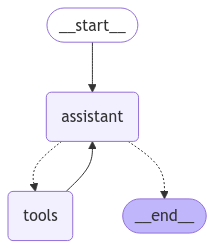

In [13]:
from IPython.display import Image, display
# Show

display(Image(react_graph.get_graph(xray=True).draw_mermaid_png()))

In [14]:
# Create unique thread id for short-term memory (checkpointer)
import uuid
thread_id = str(uuid.uuid4())
config = {"configurable": {"thread_id": thread_id}}

## Invoke ReAct Agent

In [15]:
# Specify an input
messages = [HumanMessage(content="What is the weather in Tokyo")]

# Run
messages = react_graph.invoke({"messages": messages},config)
for m in messages['messages']:
    m.pretty_print()

================================ Human Message =================================

What is the weather in Tokyo
================================== Ai Message ==================================
Tool Calls:
  tavily_search_results_json (call_0wdvhm73)
 Call ID: call_0wdvhm73
  Args:
    query: Tokyo weather
================================= Tool Message =================================
Name: tavily_search_results_json

[{"title": "Weather in Tokyo", "url": "https://www.weatherapi.com/", "content": "{'location': {'name': 'Tokyo', 'region': 'Tokyo', 'country': 'Japan', 'lat': 35.6895, 'lon': 139.6917, 'tz_id': 'Asia/Tokyo', 'localtime_epoch': 1741572554, 'localtime': '2025-03-10 11:09'}, 'current': {'last_updated_epoch': 1741572000, 'last_updated': '2025-03-10 11:00', 'temp_c': 11.1, 'temp_f': 52.0, 'is_day': 1, 'condition': {'text': 'Partly cloudy', 'icon': '//cdn.weatherapi.com/weather/64x64/day/116.png', 'code': 1003}, 'wind_mph': 4.7, 'wind_kph': 7.6, 'wind_degree': 345, 'wind_dir': 'N

In [16]:
# Specify an input
messages = [HumanMessage(content="What about Singapore")]

# Run
messages = react_graph.invoke({"messages": messages},config)
for m in messages['messages']:
    m.pretty_print()

================================ Human Message =================================

What is the weather in Tokyo
================================== Ai Message ==================================
Tool Calls:
  tavily_search_results_json (call_0wdvhm73)
 Call ID: call_0wdvhm73
  Args:
    query: Tokyo weather
================================= Tool Message =================================
Name: tavily_search_results_json

[{"title": "Weather in Tokyo", "url": "https://www.weatherapi.com/", "content": "{'location': {'name': 'Tokyo', 'region': 'Tokyo', 'country': 'Japan', 'lat': 35.6895, 'lon': 139.6917, 'tz_id': 'Asia/Tokyo', 'localtime_epoch': 1741572554, 'localtime': '2025-03-10 11:09'}, 'current': {'last_updated_epoch': 1741572000, 'last_updated': '2025-03-10 11:00', 'temp_c': 11.1, 'temp_f': 52.0, 'is_day': 1, 'condition': {'text': 'Partly cloudy', 'icon': '//cdn.weatherapi.com/weather/64x64/day/116.png', 'code': 1003}, 'wind_mph': 4.7, 'wind_kph': 7.6, 'wind_degree': 345, 'wind_dir': 'N